# Lecho fijo Actividad Especial (remake simetría, refrigerante mejorado, 4ke)
Basado (*adaptado*) de un paper de *Santiago Ortiz-Laverde, Camilo Rengifo, Martha Cobo, y Manuel Figueredo*.  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7820488/#sec2.4.1.2   
Se simula sobre mesh rectángulo en coord. cilíndricas. Se puede modelar como un cilindro 3D pero muy costoso.  

La reacción es la hidrólisis de A para dar B. El agua está en exceso.  
$A + Agua \rightarrow B$

$A: Reactivo$  
$B: Producto$

### Versión donde el refrigerante ingresa a $T=273K$ y $ke=4 ke_{original}$

Aumentando la $ke$ finalmente logré que no se supere el pico de calor. Claramente hay algo que hace que se acumule más calor del que se puede llegar a transportar y disipar, que en las simulaciones de la actividad. Se sigue convirtiendo casi el 100% del reactivo a lo largo del reactor.  
Quedaría tomar datos de un paper o algo simil y comparar contra eso... Quizás hay un error en el balance y no solo en las constantes.

![title](imgs/estacionario_T_CA_CB_Refrigerante_Mejorado_4ke.png)

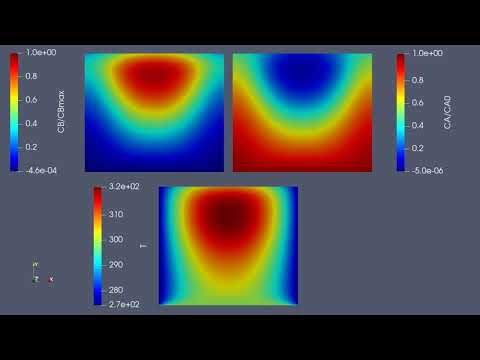

In [16]:
from IPython.display import Audio,Image, YouTubeVideo
id='P_Ji-Qd033A'
YouTubeVideo(id=id,width=960,height=540)

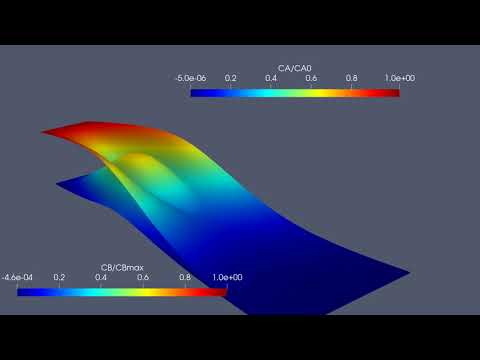

In [18]:
id='94aocgmG8gk'
YouTubeVideo(id=id,width=960,height=540)

In [1]:
from fenics import *
import numpy as np
from IPython.display import clear_output
import math as mt

In [2]:
# Time-stepping
t = 0.0
tf =20000                    # Final time, sec
num_steps = 200              # Number of time steps
delta_t = tf / num_steps     # Time step size, sec
dt = Constant(delta_t)

PBR_L = 8       # Largo del reactor, m
PBR_R = 0.3/2    # Radio del reactor, m

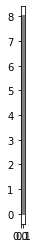

In [3]:
from mshr import *
from dolfin import Mesh, File, MeshFunction, Point, BoundaryMesh, SubDomain, plot, File
from dolfin import *
#cylinder = Cylinder(Point(0, 0, 0), Point(0, 0, PBR_L), PBR_R, PBR_R) #Cilindro (muy costoso computacionalmente)
#geometry = cylinder                                                   #Con un mesh ratio mayor a 64 ya mi ram no da...
#mesh = generate_mesh(geometry, mesh_elements_ratio)
#File("mesh/mesh.pvd") << mesh
borde_centro=0.003
class boundary(SubDomain): #General
    def inside(self, x, on_boundary):
        return on_boundary
class top_side(SubDomain): #1
    def inside(self, x, on_boundary):
        return near(x[1],PBR_L,DOLFIN_EPS)
class bottom_side(SubDomain): #2
    def inside(self, x, on_boundary):
        return near(x[1],0,DOLFIN_EPS)   
class right_side(SubDomain): #3
    def inside(self, x, on_boundary):
        return near(x[0],PBR_R,DOLFIN_EPS)
class centro(SubDomain): #4
    def inside(self, x, on_boundary):
        return near(x[0],borde_centro,DOLFIN_EPS) 

mesh = RectangleMesh(Point(borde_centro, 0), Point(PBR_R, PBR_L), 96, 96)
plot(mesh)
    
#mesh = generate_mesh(Rectangle(Point(0, 0), Point(PBR_R, PBR_L)), 96)
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
#surface_markers = MeshFunction("size_t", mesh, mesh.topology().dim(), 0)
#top_side().mark(boundary_markers, 1)
bottom_side().mark(boundary_markers, 2)
centro().mark(boundary_markers, 4) #Centro del cilindro.
right_side().mark(boundary_markers, 3)

#Caso cilindro 3D #inestable # no resuelve # costoso
#pared_cilindro().mark(boundary_markers, 3)

#File("mesh/mesh.pvd") << mesh
#File("mesh/surface_marker.pvd") << surface_markers
#File("mesh/boundary_marker.pvd") << boundary_markers #para chequear boundaries

Wallboundary_id = 3
Inletboundary_id = 2
Centroboundary_id = 4

#plot(mesh)

In [4]:
# Define function spaces for PDEs variational formulation.
P1 = FiniteElement('P', mesh.ufl_cell(), 1)  # Lagrange 1-order polynomials family
#P2 = FiniteElement('P', mesh.ufl_cell(), 2)  # Lagrange 1-order polynomials family
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

In [5]:
# Functions test y trial 
v_A, v_B, v_T = TestFunctions(V)  # Test functions
u = Function(V)
u_A, u_B, u_T = split(u)          # Trial functions, time step = n+1
u_n = Function(V)                      # Trial functions, time step = n

# Retrieve boundaries marks for Robin boundary conditions.
ds_in = Measure("ds", domain=mesh,
                subdomain_data=boundary_markers, subdomain_id=Inletboundary_id)
ds_wall = Measure("ds", domain=mesh,
                  subdomain_data=boundary_markers, subdomain_id=Wallboundary_id)
ds_centro = Measure("ds", domain=mesh,
                  subdomain_data=boundary_markers, subdomain_id=Centroboundary_id)

"""Valores iniciales (t == 0.0)"""
CAo = Constant(0.0)          # Comp. inicial para i
CBo = Constant(0.0)          # 
To = Constant(298)           # Temperatura inicial del lecho

u_0 = Expression(('CA_init', 'CB_init', 'T_init'),
                 degree=0, CA_init=CAo, CB_init=CBo, T_init=To)
u_n = interpolate(u_0, V)
u_An, u_Bn, u_Tn = split(u_n)

# Expresiones que luego aparecen en la forma variacional
R = Constant(8.314)          # Constante de los Gases

# Vector velocidad axial
Q_vol=4.2e-5 #m3/s
uz = Constant(Q_vol/(3.14159*np.power(PBR_R, 2)))
#w = as_vector([0.0, uz]) #2D #Ya no es necesario
#w = as_vector([0.0, 0.0, Vz]) #3D (cilindro) #Inestable, dificil que resuelva

T_in = Constant(298)      # Temperatura de entrada de reactivos
CA_in = Constant(0.05/4.2e-5)    #mol/m^3 #es 1190.476 mol/m3
CB_in = Constant(0)

"""Propiedades de Transporte"""
eps_b = Constant(0.3)         # epsilon_bulk (fracción de espacio vacío en lecho estimada)
ker = Constant(1.7*4)    #W/m.K   # Conductividad R
kez = Constant(1.7*4)    #W/m.K       # Conductividad Z
Dez = Constant(1.3e-5)  #m2/s        # Difusividad Z
Der = Constant(2.35e-7) #m2/s        # Difusividad R
CpM=Constant(75.36)  #J/mol.K #Cp mezcla
rhoM=Constant(5.21e4)  #mol/m3   #Rho mezcla

"""Parámetros cinéticos"""
A_k=Constant(1.696*10**13/3600) #1/s
Ea_k=Constant(78462.4) #J/mol
DeltaH = Constant(-135666) #J/mol

"""Coeficientes estequiométricos"""
coefA = Constant(-1.0)
coefB = Constant(1.0)

"""Propiedades del refrigerante (agua)"""
Twall = Constant(273) #K
Uw = Constant(1300) #W/m2.K          # Coeficiente de transporte de calor de la pared del lecho al agua

def k_r(Temperature):
    """expresión matemática de la constante cinética en función de T"""
    k = A_k * exp(-Ea_k/Temperature/R)
    return k
def Rxn(T,CA):
    return k_r(T)*CA
def robs_p(T,CA):
    return Rxn(T,CA)*(1-eps_b) #unidades=mol/s.m^3F

In [6]:
# Definición del problema variacional (F==0) #
r = Expression('x[0]', degree=1) #Variable radio
r += DOLFIN_EPS #Variable radio

F_A = 0   +((u_A-u_An)/dt)*v_A*dx                       #Termino temporal
F_A = F_A + uz*Dx(u_A,1)*v_A*dx                         #Termino convectivo
F_A = F_A + Der/r*Dx(u_A,0)*v_A*dx                      #Termino Difusivo radial 1
F_A = F_A + Der*Dx(u_A,0)*Dx(v_A,0)*dx                  #Termino Difusivo radial 2
F_A = F_A + Dez*Dx(u_A,1)*Dx(v_A,1)*dx                  #Termino Difusivo axial
F_A = F_A - coefA*robs_p(u_Tn,u_A)*v_A*dx               #Termino de generación/consumo por reacción
F_A = F_A + uz*(u_A-CA_in)*v_A*ds_in                    #Condición de frontera tipo robin para la entrada
F_A = F_A + Constant(0)*v_A*ds_centro                   #Condición de frontera tipo Neumann natural para el centro

F_B = 0   +((u_B-u_Bn)/dt)*v_B*dx                       #Termino temporal
F_B = F_B + uz*Dx(u_B,1)*v_B*dx                         #Termino convectivo
F_B = F_B + Der/r*Dx(u_B,0)*v_B*dx                      #Termino Difusivo radial 1
F_B = F_B + Der*Dx(u_B,0)*Dx(v_B,0)*dx                  #Termino Difusivo radial 2
F_B = F_B + Dez*Dx(u_B,1)*Dx(v_B,1)*dx                  #Termino Difusivo axial
F_B = F_B - coefB*robs_p(u_Tn,u_A)*v_B*dx               #Termino de generación/consumo por reacción
F_B = F_B + uz*(u_B-CB_in)*v_B*ds_in                    #Condición de frontera tipo robin para la entrada
F_B = F_B + Constant(0)*v_B*ds_centro                   #Condición de frontera tipo Neumann natural para el centro
 
F_T = 0   +(rhoM*CpM*(u_T - u_Tn)/dt)*v_T*dx            #Termino temporal
F_T = F_T + uz*rhoM*CpM*Dx(u_T,1)*v_T*dx                #Termino convectivo
F_T = F_T + ker/r*Dx(u_T,0)*v_T*dx                      #Termino Difusivo radial 1
F_T = F_T + ker*Dx(u_T,0)*Dx(v_T,0)*dx                  #Termino Difusivo radial 2
F_T = F_T + kez*Dx(u_T,1)*Dx(v_T,1)*dx                  #Termino Difusivo axial
F_T = F_T - robs_p(u_Tn,u_A)*(-DeltaH)*v_T*dx           #Termino de calor de reacción
F_T = F_T + uz*rhoM*CpM*(u_T-T_in)*v_T*ds_in            #Condición de frontera tipo robin para la entrada
F_T = F_T + Uw*(u_T - Twall)*v_T*ds_wall                #Condición de frontera tipo robin para las paredes
F_T = F_T + Constant(0)*v_T*ds_centro                   #Condición de frontera tipo Neumann natural para el centro

F = F_A + F_B + F_T

In [7]:
#Formato VTK
vtkfile_A = File('solucion_transitorio_AE_NINA_corregido/sol_CA.pvd')
vtkfile_B = File('solucion_transitorio_AE_NINA_corregido/sol_CB.pvd')
vtkfile_T = File('solucion_transitorio_AE_NINA_corregido/sol_T.pvd')
#PETScOptions.set("-mat_mumps_cntl_1", 0.05) 

clear_output(wait=True)
print('Paso 1:')
t += delta_t
solve(F == 0, u, solver_parameters={"newton_solver": { # Primer iteración con menor tolerancia
        "relative_tolerance": 1e-15,
        "absolute_tolerance": 1e-8,
        "maximum_iterations": 50}})
print('solver done (primer iter)')
_u_A, _u_B, _u_T = u_n.split()    
_u_A.rename("CA","label");_u_B.rename("CB","label");_u_T.rename("T","label")
vtkfile_A << (_u_A, t)
vtkfile_B << (_u_B, t)
vtkfile_T << (_u_T, t)
u_n.assign(u)

for n in range(num_steps):
    clear_output(wait=True)
    print('{} out of {}'.format(n+1, num_steps))
    t += delta_t  # Actualizamos el tiempo

    # Resolvemos el problema variacional para este time step
    solve(F == 0, u, solver_parameters={"newton_solver": {
            "relative_tolerance": 1e-15,
            "absolute_tolerance": 1e-6,
            "maximum_iterations": 20}})
    print('solver done')

    # Guardamos solución
    _u_A, _u_B, _u_T = u_n.split()    
    _u_A.rename("CA","label")
    _u_B.rename("CB","label")
    _u_T.rename("T","label")
    vtkfile_A << (_u_A, t)
    vtkfile_B << (_u_B, t)
    vtkfile_T << (_u_T, t)

    u_n.assign(u)
clear_output(wait=True)
print("Done")

Done


Último perfil para A a lo largo de r y z


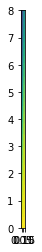

In [8]:
print("Último perfil para A a lo largo de r y z")
plot(_u_A)

Último perfil para T a lo largo de r y z


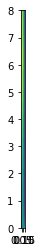

In [9]:
print("Último perfil para T a lo largo de r y z")
plot(_u_T)

In [10]:
#error a proposito

## OJO
Ejecutar los bloques de abajo puede llegar a hacer que no se pueda graficar más con el plot "nativo" de FEniCS (como para generar el gráfico de arriba).  
También hay algún bug con mezclar gráficos de Matplotlib y las calls de FEniCS a Matplotlib. Para solucionar esos gráficos, realizar todos, y volver a hacer los de perfiles 2D. Luego re-ejecutar los 3D. je (esto rompe los calls de FEniCS).

In [30]:
z=5
CR=[]
CA=[]
CB=[]
CT=[]
for r in np.linspace(borde_centro,PBR_R,100):
    CR.append(r)
    CA.append(_u_A(r,z))
    CB.append(_u_B(r,z))
    CT.append(_u_T(r,z))

<IPython.core.display.Javascript object>


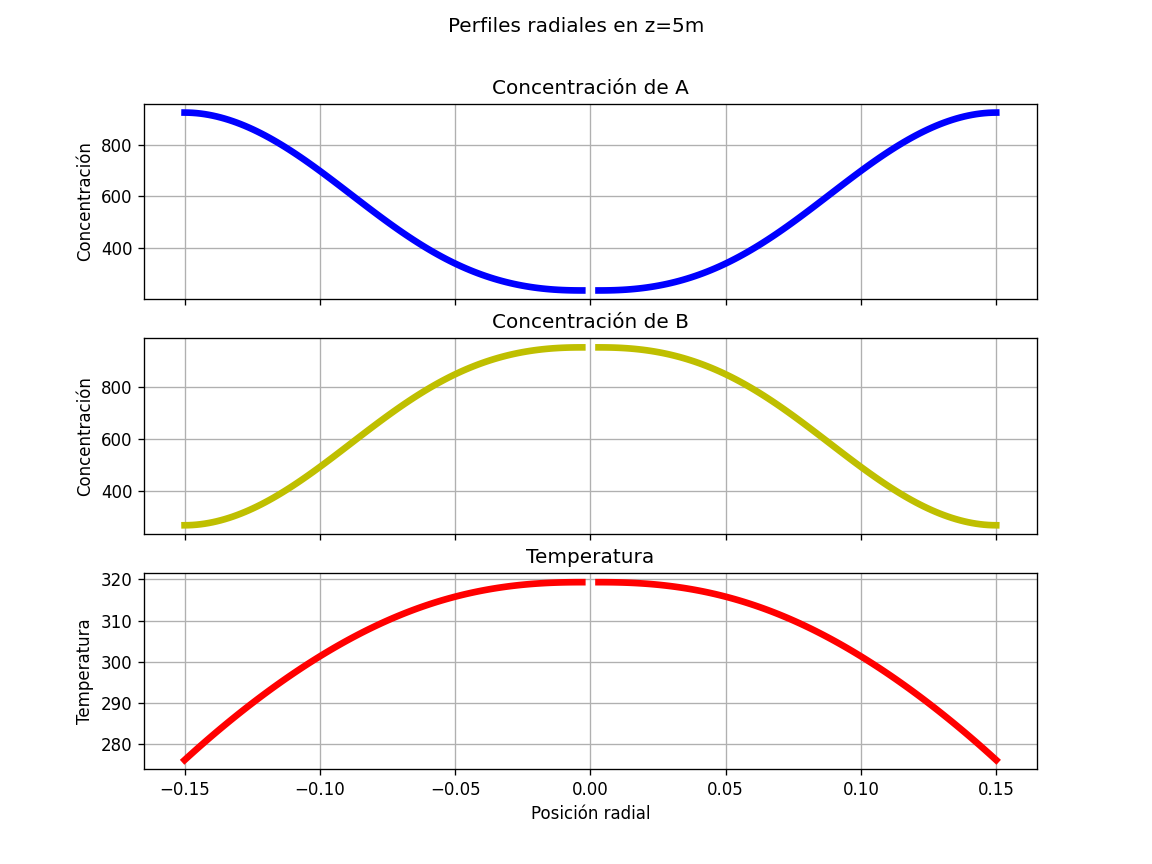

<function matplotlib.pyplot.ion()>

In [31]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion
#plt.plot(CA)
#plt.plot(CC)
X=np.asarray(CR)
Y1=CA
Y2=CB
Y3=CT
fig, axs = plt.subplots(3,sharex=True,figsize=(19.20/2,10.80/1.5)) #equivale a 1920x1080
plt.xlabel("Posición radial")
fig.suptitle("Perfiles radiales en z="+str(z)+"m")

axs[0].set(ylabel="Concentración")
axs[0].plot(-X, Y1,linewidth=4,color='b')                   #gráfico de líneas
axs[0].plot(X, Y1,linewidth=4,color='b')
axs[0].grid() #grilla
#axs[0].set_xlim([2002, 2018]) #opcional definir rango para X, aplica a los 3 gráficos en conjunto
axs[0].set_title('Concentración de A')

axs[1].set(ylabel="Concentración")
axs[1].plot(-X, Y2,linewidth=4,color='y')
axs[1].plot(X, Y2,linewidth=4,color='y')
axs[1].grid()
axs[1].set_title('Concentración de B')

axs[2].set(ylabel="Temperatura")
axs[2].plot(-X, Y3,linewidth=4,color='r')
axs[2].plot(X, Y3,linewidth=4,color='r')
axs[2].grid()
axs[2].set_title('Temperatura')
plt.ion

In [35]:
z=0.30
CR=[]
CA=[]
CB=[]
CT=[]
for r in np.linspace(borde_centro,PBR_R,100):
    CR.append(r)
    CA.append(_u_A(r,z))
    CB.append(_u_B(r,z))
    CT.append(_u_T(r,z))

<IPython.core.display.Javascript object>


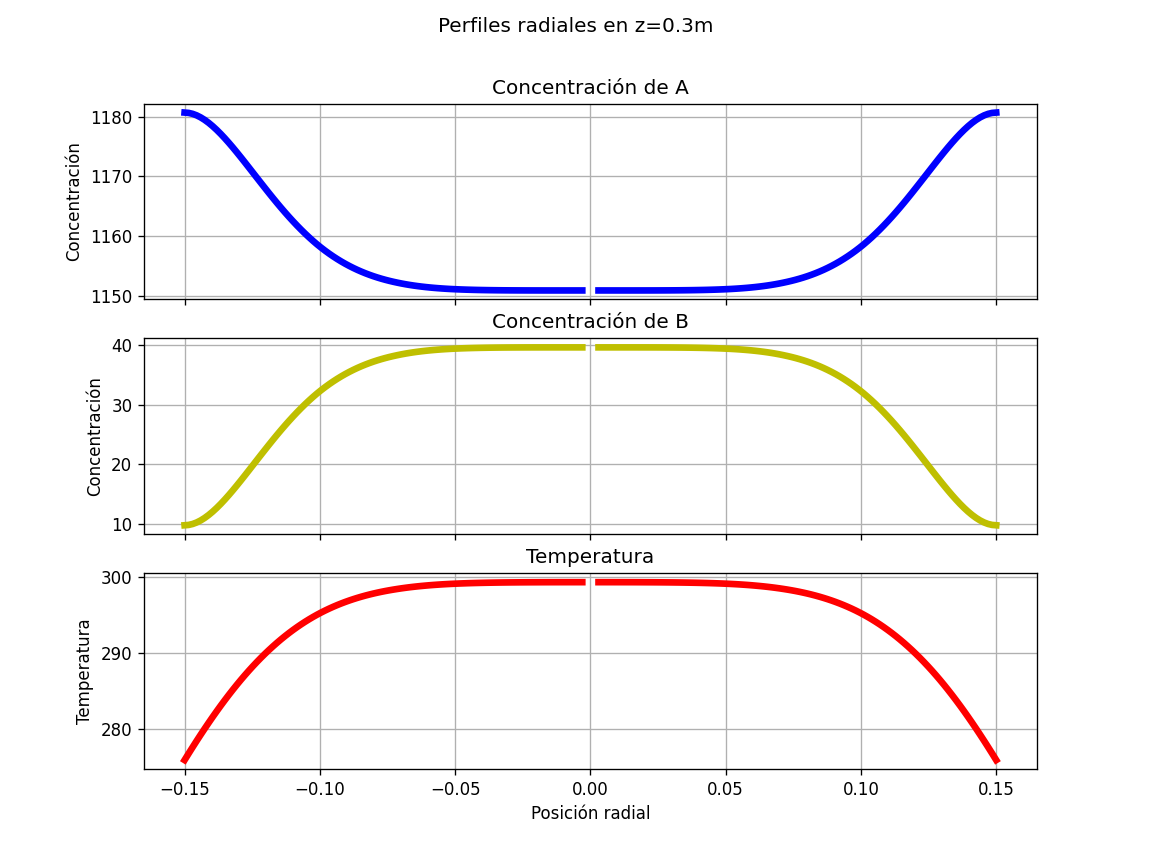

<function matplotlib.pyplot.ion()>

In [36]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion
#plt.plot(CA)
#plt.plot(CC)
X=np.asarray(CR)
Y1=CA
Y2=CB
Y4=CT
fig, axs = plt.subplots(3,sharex=True,figsize=(19.20/2,10.80/1.5)) #equivale a 1920x1080
plt.xlabel("Posición radial")
fig.suptitle("Perfiles radiales en z="+str(z)+"m")

axs[0].set(ylabel="Concentración")
axs[0].plot(-X, Y1,linewidth=4,color='b')                  #gráfico de líneas
axs[0].plot(X, Y1,linewidth=4,color='b')
axs[0].grid() #grilla
#axs[0].set_xlim([2002, 2018]) #opcional definir rango para X, aplica a los 3 gráficos en conjunto
axs[0].set_title('Concentración de A')

axs[1].set(ylabel="Concentración")
axs[1].plot(-X, Y2,linewidth=4,color='y')
axs[1].plot(X, Y2,linewidth=4,color='y')
axs[1].grid()
axs[1].set_title('Concentración de B')

axs[2].set(ylabel="Temperatura")
axs[2].plot(-X, Y4,linewidth=4,color='r')
axs[2].plot(X, Y4,linewidth=4,color='r')
axs[2].grid()
axs[2].set_title('Temperatura')
plt.ion

In [26]:
r=borde_centro #es cero
CZ=[]
CA=[]
CB=[]
CT=[]
for z in np.linspace(0,PBR_L,100):
    CZ.append(z)
    CA.append(_u_A(r,z))
    CB.append(_u_B(r,z))
    CT.append(_u_T(r,z))

<IPython.core.display.Javascript object>


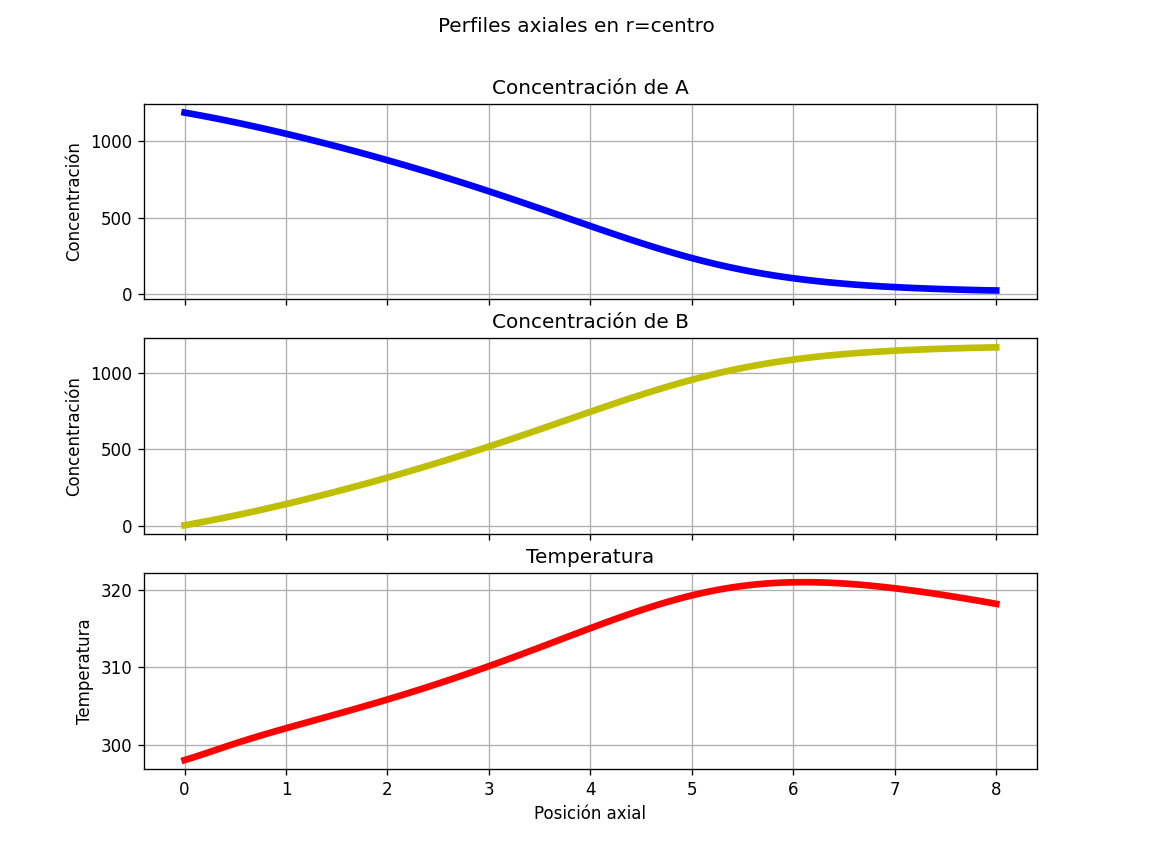

<function matplotlib.pyplot.ion()>

In [27]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion
#plt.plot(CA)
#plt.plot(CC)
X=CZ
Y1=CA
Y2=CB
Y3=CT
fig, axs = plt.subplots(3,sharex=True,figsize=(19.20/2,10.80/1.5)) #equivale a 1920x1080
plt.xlabel("Posición axial")
fig.suptitle("Perfiles axiales en r=centro")

axs[0].set(ylabel="Concentración")
axs[0].plot(X, Y1,linewidth=4,color='b')                   #gráfico de líneas
axs[0].grid() #grilla
#axs[0].set_xlim([2002, 2018]) #opcional definir rango para X, aplica a los 3 gráficos en conjunto
axs[0].set_title('Concentración de A')

axs[1].set(ylabel="Concentración")
axs[1].plot(X, Y2,linewidth=4,color='y')
axs[1].grid()
axs[1].set_title('Concentración de B')

axs[2].set(ylabel="Temperatura")
axs[2].plot(X, Y3,linewidth=4,color='r')
axs[2].grid()
axs[2].set_title('Temperatura')
plt.ion

In [17]:
%matplotlib notebook
plt.ion
from mpl_toolkits import mplot3d
CR=[]
CZ=[]
CA=[]
CB=[]
CT=[]
for r in np.linspace(borde_centro,PBR_R,100):
    for z in np.linspace(0,PBR_L,100):
        CR.append(-r)
        CZ.append(z)
        CA.append(_u_A(r,z))
        CB.append(_u_B(r,z))
        CT.append(_u_T(r,z))
        CR.append(r)
        CZ.append(z)
        CA.append(_u_A(r,z))
        CB.append(_u_B(r,z))
        CT.append(_u_T(r,z))
CR=np.array(CR)
CZ=np.array(CZ)
CA=np.array(CA)
CB=np.array(CB)
CT=np.array(CT)

<IPython.core.display.Javascript object>


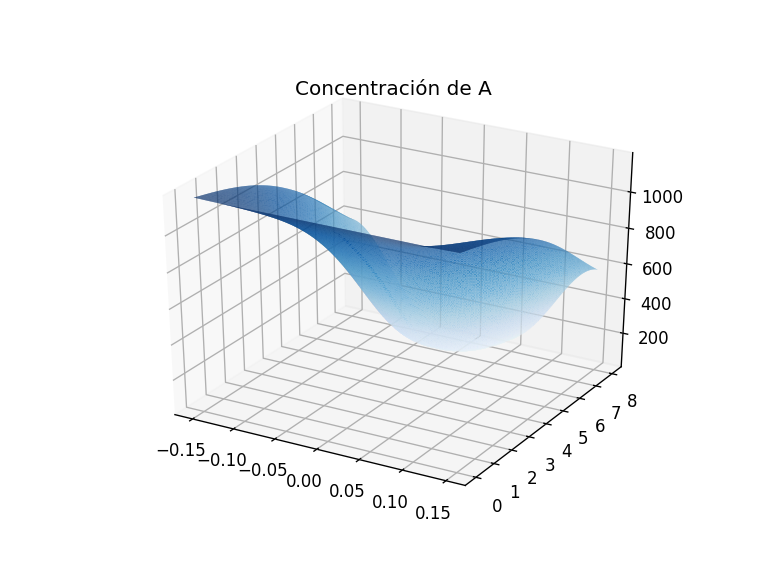

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf(CR,CZ,CA, cmap=plt.cm.Blues)
ax.set_title('Concentración de A')
plt.show()

<IPython.core.display.Javascript object>


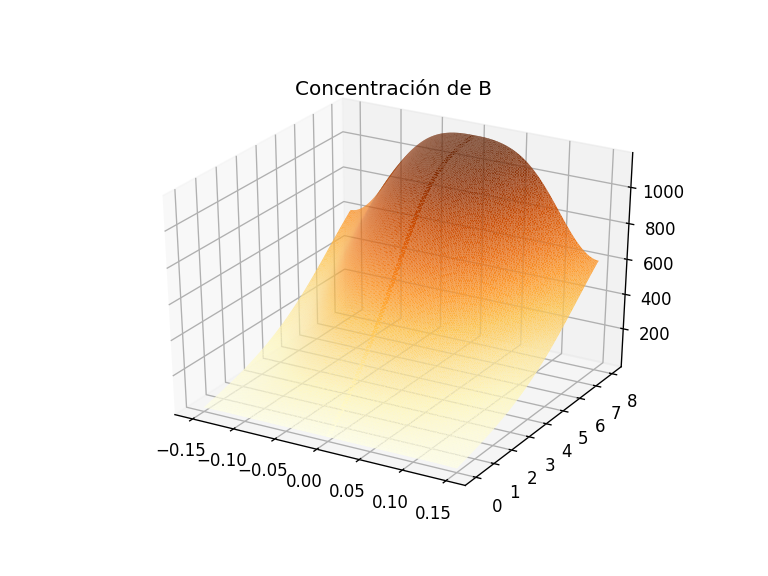

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf(CR,CZ,CB, cmap=plt.cm.YlOrBr)
ax.set_title('Concentración de B')
plt.show()

<IPython.core.display.Javascript object>


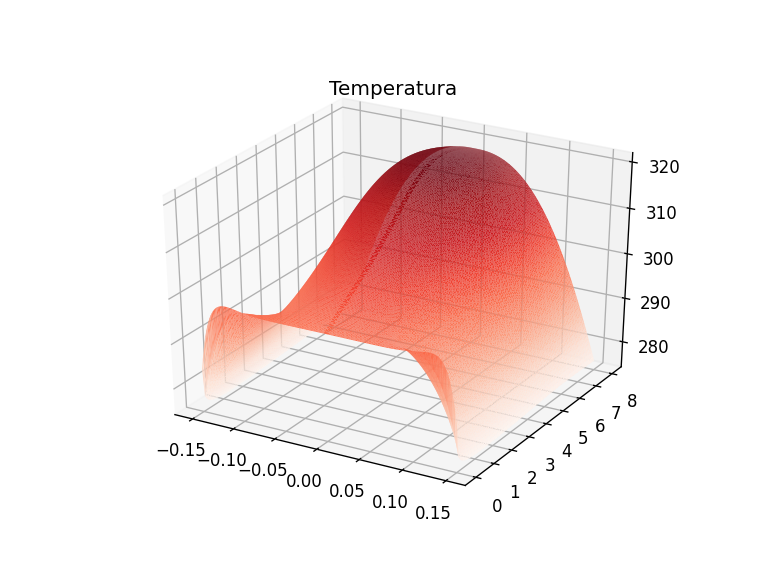

In [20]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf(CR,CZ,CT, cmap=plt.cm.Reds)
ax.set_title('Temperatura')
plt.show()